In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score, accuracy_score, mean_squared_error

RSEED =  42

In [2]:
df = pd.read_csv("data/Train.csv")
df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [3]:
df.nunique()

ID        107833
DATOP       1011
FLTID       1861
DEPSTN       132
ARRSTN       128
STD        81697
STA        85136
STATUS         5
AC            68
target       968
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


In [5]:
df.describe()

,target
count,107833.000000
mean,48.733013
std,117.135562
min,0.000000
25%,0.000000
50%,14.000000
75%,43.000000
max,3451.000000


In [6]:
df['STA'].replace('\.',':', regex=True,inplace=True)

In [7]:
df['STD'] = pd.to_datetime(df['STD'])
df['STA'] = pd.to_datetime(df['STA'])
df['DATOP'] = pd.to_datetime(df['DATOP'])

In [8]:
df['time_diff'] = (df['STA']-df['STD']).dt.total_seconds()/60

In [9]:
# Create years, month etc.
df['hour'] = df.STD.dt.hour
df['month'] = df.DATOP.dt.month
df['year'] = df.DATOP.dt.year
df['day_of_week'] = df.DATOP.dt.day_of_week # The day of the week with Monday=0, Sunday=6

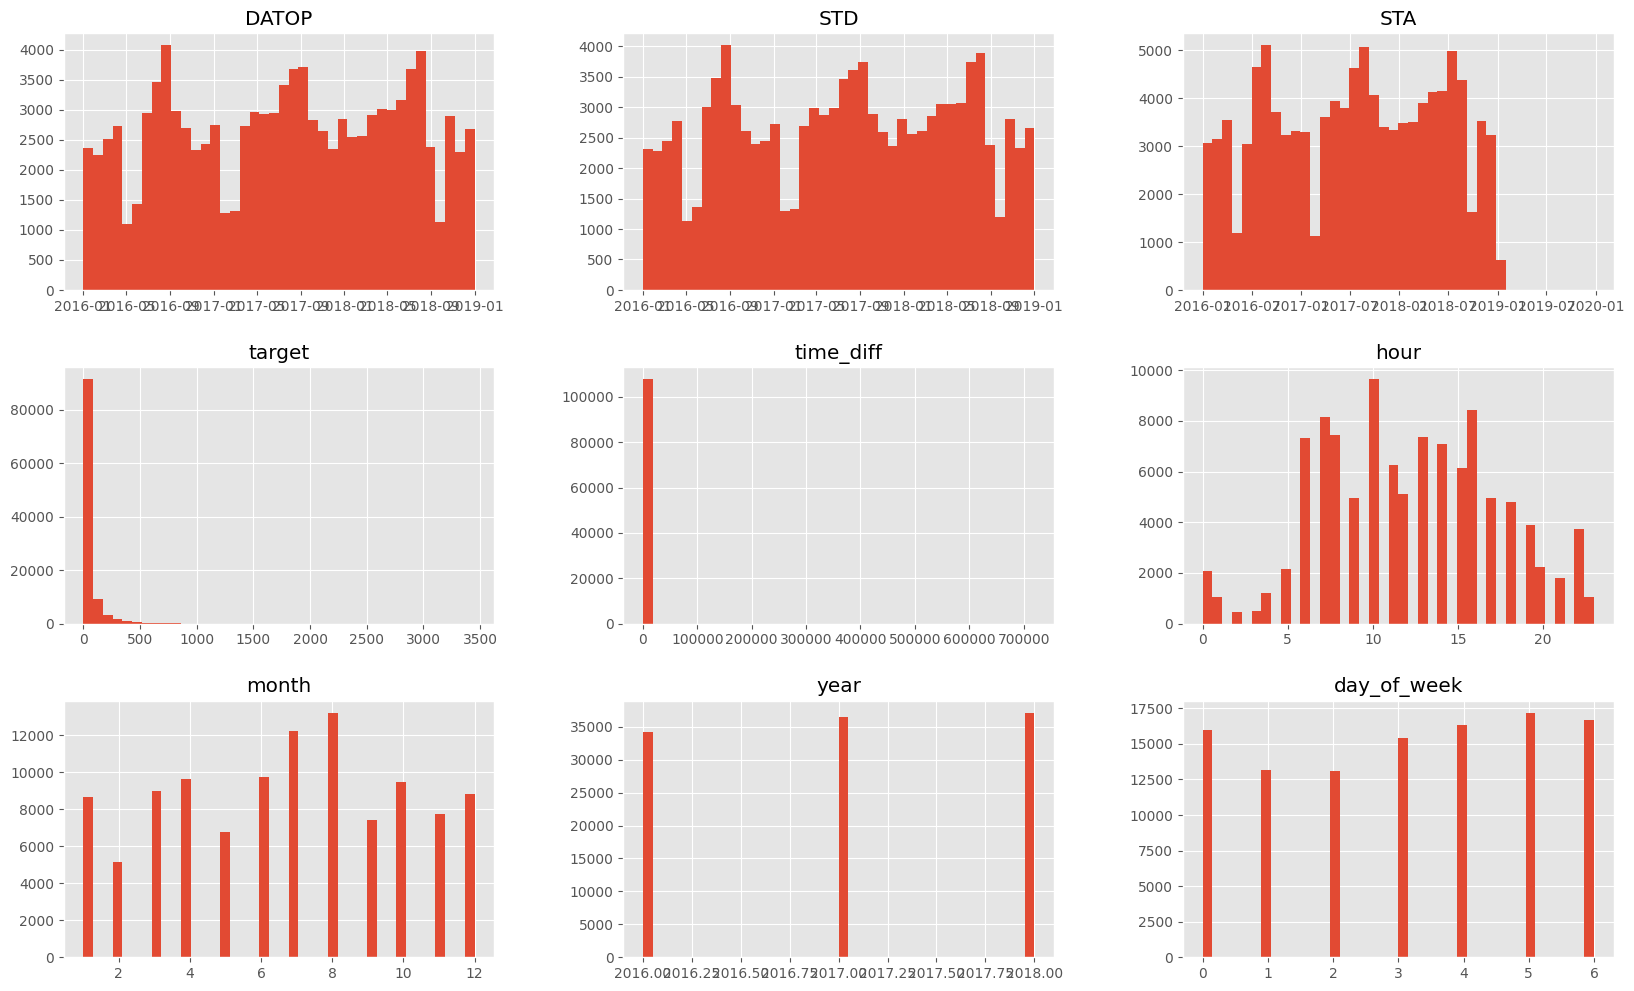

In [10]:
df.hist(bins=40, figsize=(20, 12))
plt.show()

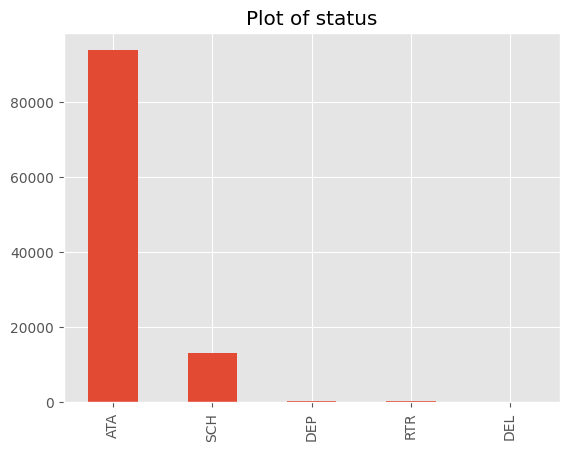

In [11]:
#plot of Status
status_count = df.STATUS.value_counts() 
#(status_count/df.shape[0]).plot(kind="bar")
status_count.plot(kind="bar")
plt.title("Plot of status");

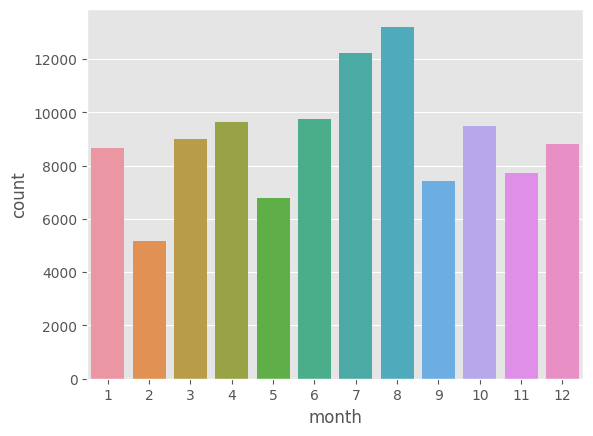

In [12]:
sns.countplot(df['month']);

In [13]:
#outcome = df.pop("target")
#np.array(outcome)
#outcome = (outcome ==0.0).astype(int)
#outcome.value_counts()

In [14]:
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,time_diff,hour,month,year,day_of_week
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,145.0,10,1,2016,6
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,110.0,15,1,2016,2
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,155.0,4,1,2016,5
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,170.0,14,1,2016,6
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,80.0,14,1,2016,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,SCH,TU 32AIML,0.0,180.0,23,7,2018,3
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,SCH,UG AT7AT7,0.0,60.0,8,1,2018,5
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,SCH,TU 736IOK,0.0,470.0,5,11,2018,2
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,ATA,TU CR9ISA,0.0,45.0,18,1,2018,1


Text(0, 0.5, 'mean delay in minutes')

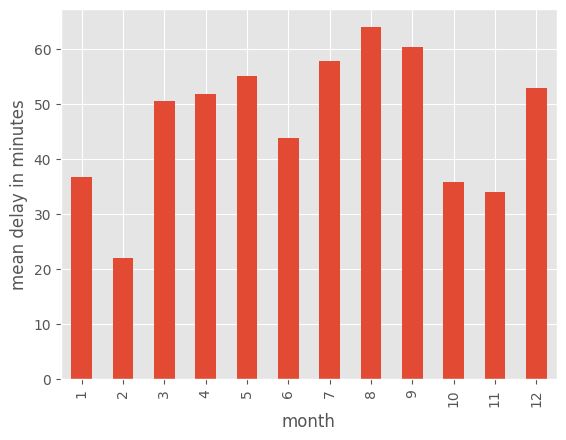

In [15]:
plt.figure()
df.groupby('month')['target'].mean().plot(kind='bar')
plt.ylabel('mean delay in minutes')

In [16]:
df_cleaned = df.copy()

In [17]:
le2 = LabelEncoder()
le2.fit(df_cleaned['FLTID'])
le2.transform(df_cleaned['FLTID'])
df_cleaned['FLTID'] = le2.transform(df_cleaned['FLTID'])

In [18]:
df_cleaned.drop(['ID','DATOP', 'DEPSTN','ARRSTN','STD','STA','STATUS','year'],axis=1,inplace=True)

In [19]:
df_cleaned.drop(['FLTID'],axis=1,inplace=True)

In [20]:
df_cleaned

,AC,target,time_diff,hour,month,day_of_week
0,TU 32AIMN,260.0,145.0,10,1,6
1,TU 31BIMO,20.0,110.0,15,1,2
2,TU 32AIMN,0.0,155.0,4,1,5
3,TU 736IOK,0.0,170.0,14,1,6
4,TU 320IMU,22.0,80.0,14,1,6
...,...,...,...,...,...,...
107828,TU 32AIML,0.0,180.0,23,7,3
107829,UG AT7AT7,0.0,60.0,8,1,5
107830,TU 736IOK,0.0,470.0,5,11,2
107831,TU CR9ISA,0.0,45.0,18,1,1


In [21]:
df1_raw = df_cleaned.copy()
features = pd.get_dummies(df1_raw, columns = ['AC'], drop_first=True)
features

,target,time_diff,hour,month,day_of_week,AC_5K 345TFX,AC_5M 343FOX,AC_5M 343JAI,AC_5M 343SUN,AC_6P M87TRJ,...,AC_TU CR9ISA,AC_TU CR9XXX,AC_UG AT7AT7,AC_UG AT7LBD,AC_UG AT7LBE,AC_UG CR9CR9,AC_UG CR9ISA,AC_UG CR9XXX,AC_UJ 320TCF,AC_X9 320VEB
0,260.0,145.0,10,1,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20.0,110.0,15,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,155.0,4,1,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,170.0,14,1,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22.0,80.0,14,1,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,0.0,180.0,23,7,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107829,0.0,60.0,8,1,5,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
107830,0.0,470.0,5,11,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107831,0.0,45.0,18,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
target = np.array(features.pop("target"))

In [23]:
# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RSEED)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 86266 samples.
Testing set has 21567 samples.


In [24]:
X_train

,time_diff,hour,month,day_of_week,AC_5K 345TFX,AC_5M 343FOX,AC_5M 343JAI,AC_5M 343SUN,AC_6P M87TRJ,AC_BJ 320INA,...,AC_TU CR9ISA,AC_TU CR9XXX,AC_UG AT7AT7,AC_UG AT7LBD,AC_UG AT7LBE,AC_UG CR9CR9,AC_UG CR9ISA,AC_UG CR9XXX,AC_UJ 320TCF,AC_X9 320VEB
30962,35.0,15,11,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
34625,90.0,16,6,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76736,180.0,16,6,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52580,275.0,0,8,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97130,85.0,15,12,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54886,145.0,6,12,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76820,85.0,12,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103694,60.0,16,7,6,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
860,100.0,16,1,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Instantiate our model 
lin_reg = LinearRegression()

# Train the model using our data
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [26]:
# Calcualte the R-squared for our model
print("R-squared:", r2_score(y_test, y_pred).round(3))
print("RMSE-squared:", mean_squared_error(y_test, y_pred, squared=False).round(3))

R-squared: 0.029
RMSE-squared: 115.939


In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sys
from io import StringIO

In [28]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [29]:
X_train

,time_diff,hour,month,day_of_week,AC_5K 345TFX,AC_5M 343FOX,AC_5M 343JAI,AC_5M 343SUN,AC_6P M87TRJ,AC_BJ 320INA,...,AC_TU CR9ISA,AC_TU CR9XXX,AC_UG AT7AT7,AC_UG AT7LBD,AC_UG AT7LBE,AC_UG CR9CR9,AC_UG CR9ISA,AC_UG CR9XXX,AC_UJ 320TCF,AC_X9 320VEB
30962,35.0,15,11,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
34625,90.0,16,6,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76736,180.0,16,6,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52580,275.0,0,8,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97130,85.0,15,12,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54886,145.0,6,12,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76820,85.0,12,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103694,60.0,16,7,6,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
860,100.0,16,1,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
X_train_sc

array([[-0.03559927,  0.56034021,  1.31316366, ..., -0.02681836,
        -0.01318753, -0.00900838],
       [-0.02574105,  0.75408947, -0.20788173, ..., -0.02681836,
        -0.01318753, -0.00900838],
       [-0.00960944,  0.75408947, -0.20788173, ..., -0.02681836,
        -0.01318753, -0.00900838],
       ...,
       [-0.03111826,  0.75408947,  0.09632735, ..., -0.02681836,
        -0.01318753, -0.00900838],
       [-0.02394865,  0.75408947, -1.72892712, ..., -0.02681836,
        -0.01318753, -0.00900838],
       [-0.02842966, -0.40840608, -0.81629988, ..., -0.02681836,
        -0.01318753, -0.00900838]])

In [31]:
# Instantiate our model 
lin_reg_sc = LinearRegression()

lin_reg_sc.fit(X_train_sc, y_train)
y_pred_sc = lin_reg_sc.predict(X_test_sc)

In [32]:
print("R-squared_sc:", r2_score(y_test, y_pred_sc).round(3))
print("RMSE-squared_sc:", mean_squared_error(y_test, y_pred_sc, squared=False).round(3))

R-squared_sc: 0.029
RMSE-squared_sc: 115.939


In [33]:
importances = pd.DataFrame({'feature':df_cleaned.columns,'importance':np.round( lin_reg.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print("The feature importances are shown below: ",importances)
      # bar plot of the feature importances
      
importances.plot(kind = 'barh')
plt.title("Important features in determining whether a flight is delayed ")
plt.ylabel('Feature importances')
plt.xlabel('Features')
plt.show()

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [35]:
# Import sklearn.preprocessing.StandardScaler

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
numerical = ['year', 'time_diff']
X_train_sc[numerical] = scaler.fit_transform(X_train_sc[numerical])
X_test_sc[numerical] = scaler.transform(X_test_sc[numerical])

# Show an example of a record with scaling applied
pd.DataFrame(X_train_sc[numerical])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices